In [1]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        x4 = self.final(x3)
        return x4


In [2]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

class CustomDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')

        label_path = os.path.join(self.label_dir, self.image_files[idx].replace('.jpg', '.npy'))
        label = np.load(label_path)
        label = label[:, :, 0] // 255  # Convert pixel values to class indices (0 or 1)

        if self.transform:
            img = self.transform(img)

        return img, torch.from_numpy(label).long()


In [3]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Create dataset and data loader
train_dataset = CustomDataset('/content/drive/MyDrive/dataset/images/train', '/content/drive/MyDrive/dataset/labels/train', transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

val_dataset = CustomDataset('/content/drive/MyDrive/dataset/images/val', '/content/drive/MyDrive/dataset/labels/val', transform=ToTensor())
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [4]:
# Create the UNet model
model = UNet(in_channels=3, out_channels=2)  # Replace C with the number of classes in your segmentation task

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train and validate the model
num_epochs = 10

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # Removed .cuda() for data and target
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            # Removed .cuda() for data and target
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')



Epoch 1/10, Train Loss: 0.2667, Validation Loss: 0.2449
Epoch 2/10, Train Loss: 0.2385, Validation Loss: 0.2266
Epoch 3/10, Train Loss: 0.2286, Validation Loss: 0.2120
Epoch 4/10, Train Loss: 0.2178, Validation Loss: 0.2122
Epoch 5/10, Train Loss: 0.2117, Validation Loss: 0.2077
Epoch 6/10, Train Loss: 0.2093, Validation Loss: 0.2006
Epoch 7/10, Train Loss: 0.2051, Validation Loss: 0.1992
Epoch 8/10, Train Loss: 0.2088, Validation Loss: 0.1961
Epoch 9/10, Train Loss: 0.2058, Validation Loss: 0.1934
Epoch 10/10, Train Loss: 0.2121, Validation Loss: 0.1959


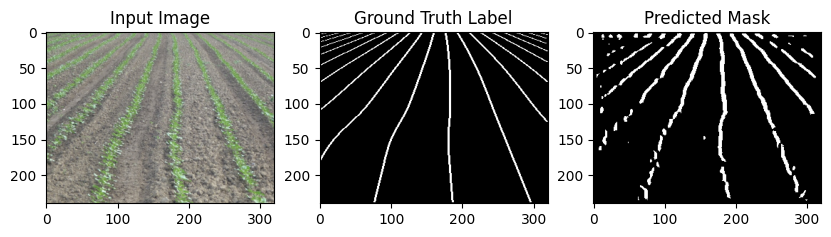

In [123]:
import matplotlib.pyplot as plt

# Load a single image and its corresponding label
img_path = "/content/drive/MyDrive/dataset/images/val/crop_row_227.jpg"
label_path = "/content/drive/MyDrive/dataset/labels/val/crop_row_227.npy"
img = Image.open(img_path).convert('RGB')
label = np.load(label_path)[:, :, 0] // 255

# Preprocess the image and run it through the model
img_tensor = ToTensor()(img).unsqueeze(0)
output = model(img_tensor).squeeze(0)
output = output.detach().numpy()[1,:,:]
output_scaled = (output-output.min())/(output.max()-output.min())
output = np.where(output_scaled > 0.85, 1, 0)

# Plot the input image, label, and predicted mask
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(img)
axs[0].set_title('Input Image')
axs[1].imshow(label, cmap='gray')
axs[1].set_title('Ground Truth Label')
axs[2].imshow(output, cmap='gray')
axs[2].set_title('Predicted Mask')
plt.show()

In [124]:
overlap = label*output
union = label+output
IOU = overlap.sum()/float(union.sum())
print(IOU)

0.20442139737991266


In [125]:
def test_img_output(img_path):
  img = Image.open(img_path).convert('RGB')

  img_tensor = ToTensor()(img).unsqueeze(0)
  output = model(img_tensor).squeeze(0)
  output = output.detach().numpy()[1,:,:]
  output_scaled = (output-output.min())/(output.max()-output.min())
  output = np.where(output_scaled > 0.85, 1, 0)
  return(output)

In [126]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/dataset/train and test ids.csv")

In [127]:
test_ids = list(df["test_ids"].dropna().astype(int))

In [128]:
output_arrays = []
for ids in test_ids:
  str_id = str(ids)
  if len(str_id)==1:
    str_id = "00"+str_id
  elif len(str_id) == 2:
    str_id = "0"+str_id
  img_path = "/content/drive/MyDrive/dataset/images/test/crop_row_"+str_id+".jpg"
  output_arr = test_img_output(img_path)
  output_arrays.append(output_arr)

In [131]:
len(output_arrays)

71

In [134]:
def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    255 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [146]:
encoding_list = []
for i in range(len(output_arrays)):
  encoding_list.append(encode_mask_to_rle(output_arrays[i]))

In [147]:
data = {'ids': test_ids, 'labels': encoding_list}

In [149]:
final_data = pd.DataFrame(data)

In [150]:
final_data.to_csv("submission_1_aml.csv")

In [151]:
from google.colab import files
files.download("submission_1_aml.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>